In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
from scipy.stats import norm
from scipy import stats
import seaborn as sns
import math
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# carreguei a base de dados como um dataframe e removi os valores duplicados e nulos
df = pd.read_csv('Delivery.csv')

# criando listas para ficar mais facil de usar nas estruturas de repetição a seguir
columns_to_clean = ['awaited_time', 'store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items',
'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders'
, 'estimated_store_to_consumer_driving_duration']
valoresNegativos = []

# removendo os valores negativos e nulos do database
for column in columns_to_clean:
  for a in range(len(df)):
    if df[column].iloc[a] <= 0:
      valoresNegativos.append(a)

# armazenei as linhas em uma lista para poder removê-las
df = df.drop(valoresNegativos, axis = 'index')

# removemos valores vazios e duplicados
df.dropna(inplace=True)
df = df.drop_duplicates()

# fazendo a limpeza dos valores discrepantes
threshold = 3

for column in columns_to_clean:
  q1 = df[column].quantile(0.25)
  q3 = df[column].quantile(0.75)
  iqr = q3 - q1

  upper_bound = q3 + threshold * iqr
  lower_bound = q1 - threshold * iqr

  df = df[((df[column] <= upper_bound) & (df[column] >= lower_bound))]
# a diferença interquartil foi o unico metodo que eu consegui aplicar para remover
# os outliers, visto que os valores estavam absurdamente discrepantes
# até tentei remover por z-mean que é o padrão, porém nesse database não consegui de maneira eficiente

df.shape

(113123, 16)

# **ANALISE**

## ANALISE INICIAL

In [ ]:
# criando a tabela de descrição
df_describe = df.describe()
df_describe.loc['amp'] = df_describe.loc['max'] - df_describe.loc['min']
df_describe.loc['cv'] = (df_describe.loc['std'] / df_describe.loc['mean']).abs() * 100
df_describe.loc['skewness'] = df.skew()

df_describe.round(2)
# incrementei os valores de amplitude, coeficiente de variação e assimetria para poder analisar melhor

<ipython-input-4-7b80bb3e2195>:5: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_describe.loc['skewness'] = df.skew()


,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,awaited_time
count,113109.00,113551.00,113551.00,113551.00,113551.00,113551.00,113551.00,113551.00,113551.00,113551.00,113551.00,113551.00,113551.00
mean,2.85,36.13,2.90,2.97,2577.15,2.58,678.67,1132.02,47.99,41.51,60.65,9.10,45.55
std,1.33,20.84,1.51,1.79,1560.63,1.44,453.14,465.41,35.85,31.48,54.41,3.65,8.95
min,1.00,1.00,1.00,1.00,125.00,1.00,8.00,75.00,1.00,1.00,1.00,0.05,32.00
25%,2.00,18.00,1.00,2.00,1400.00,1.00,300.00,800.00,19.00,15.00,18.00,6.40,39.00
50%,3.00,39.00,3.00,3.00,2198.00,2.00,599.00,1079.00,40.00,34.00,42.00,9.05,44.00
75%,4.00,55.00,4.00,4.00,3335.00,3.00,945.00,1395.00,70.00,62.00,91.00,11.72,51.00
max,6.00,72.00,7.00,10.00,9340.00,9.00,2900.00,3180.00,171.00,148.00,283.00,25.42,91.00
amp,5.00,71.00,6.00,9.00,9215.00,8.00,2892.00,3105.00,170.00,147.00,282.00,25.37,59.00
cv,46.85,57.67,52.09,60.16,60.56,55.87,66.77,41.11,74.70,75.84,89.71,40.08,19.65


Dado os valores obtidos com o describe, podemos fazer uma análise inicial de que o subtotal tem uma amplitude muito grande, o que pode estar relacionado com o tempo de entrega, visto que quanto maior o valor do total tende a ter mais itens.
Outros indices que podem ser analisados juntos é o de total de itens e o de numero distinto de itens, o qual podemos perceber que ambos tem a média perto de 3, o que nos indica que os clientes geralmente tendem a pedir itens diferentes em seus pedidos, e em grande das vezes não se repetem itens.
Também pode-se pensar sobre o tempo de entrega, que tem como média 9.1 minutos, o que indica que os pedidos geralmente são pedidos por pessoas que moram perto do local, e o mais distante demora em torno de 25 minutos a entrega.

<ipython-input-5-c446f6a3efaa>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, fmt='.2f')


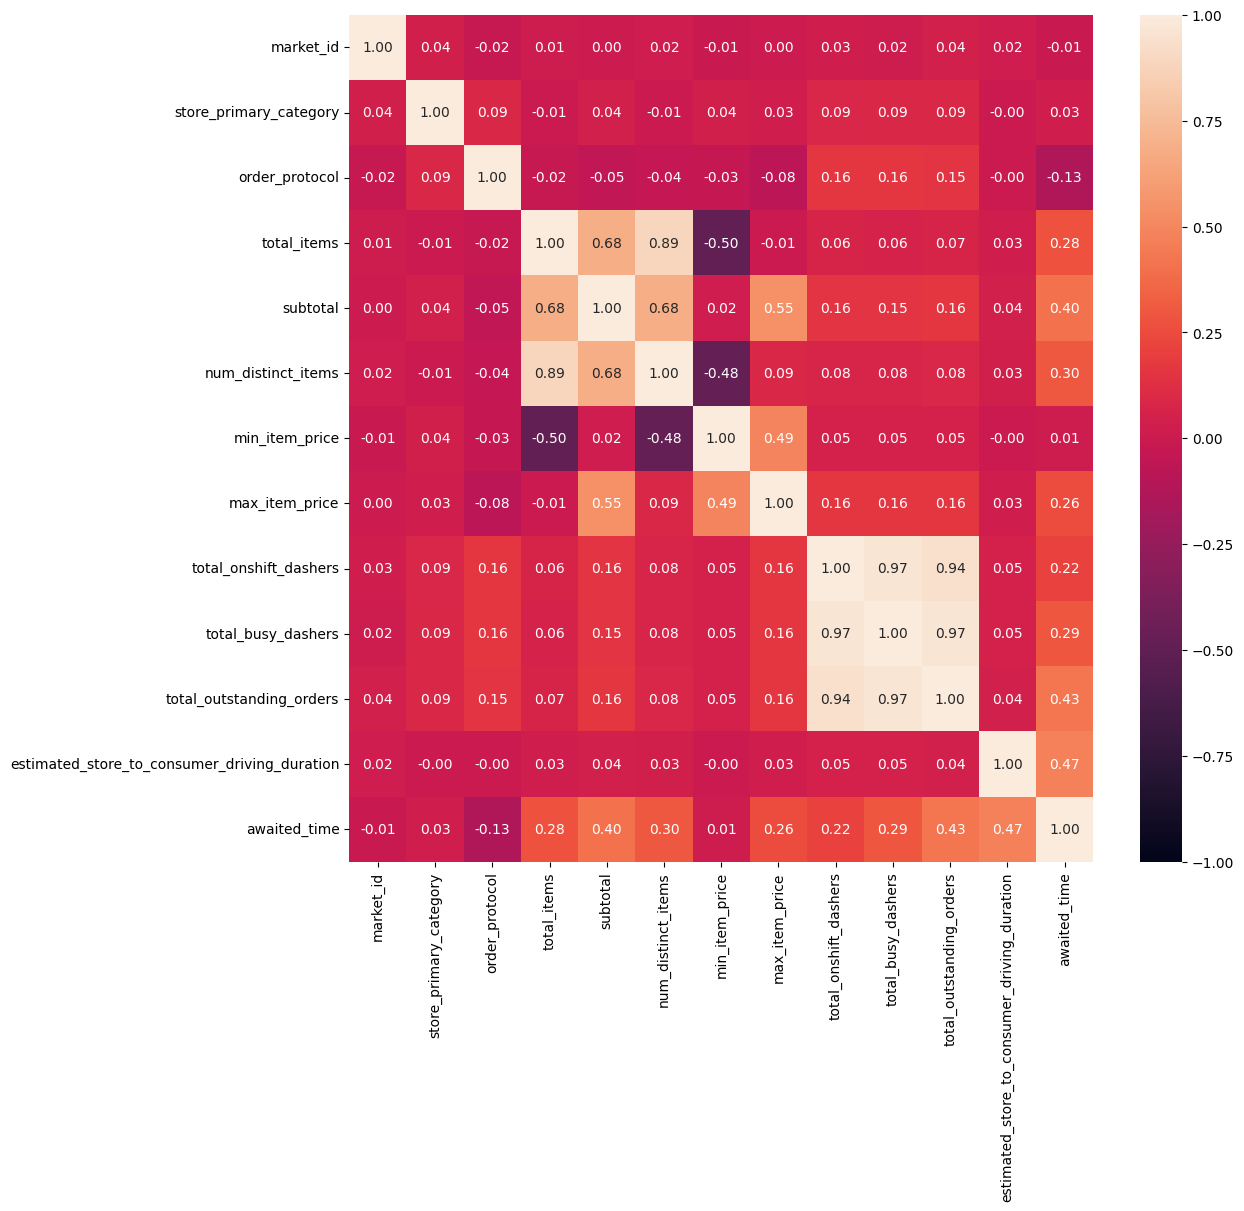

In [ ]:
# criando um heatmap para poder analisar as correlações entre cada variável
plt.figure(figsize=(12, 11))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, fmt='.2f')
plt.show()

Como temos que analisar a questão da entrega, restringirei minha analise pelo tempo de entrega.
Dado isso podemos perceber que a correlação entre o tempo de entrega e as outras variaveis são diretamente proporcionais, ou seja, maiores tempos de entrega tendem a ter maiores quantidades de produtos (como exemplo). Sendo assim podemos ver que as maiores correlações são entre o tempo de viagem para entrega, o total de pedidos pendentes, o subtotal, o numero distinto de produtos e o total de entregadores ocupados.
Portanto, basearei minhas conclusões nas analises desses dados como princípio.

## ANALISE GERAL

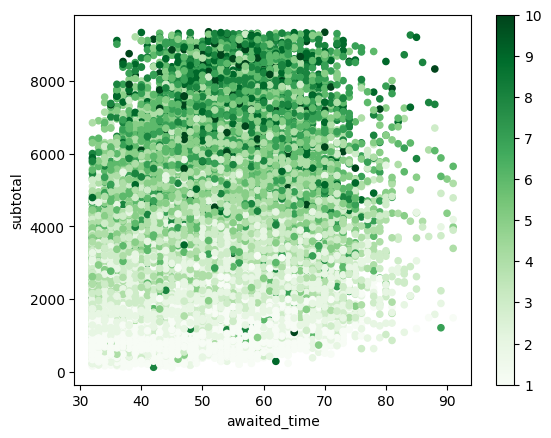

In [ ]:
# criando um grafico para poder analisar a relação entre tempo de espera, subtotal e total de itens
df.plot(x='awaited_time', y='subtotal', c=df['total_items'],
           cmap = 'Greens',kind='scatter')
plt.show()

Geralmente quanto mais pedidos fazemos e maior o valor total do pedido tende a demorar mais, pois em tese era pra ter mais produtos a se fazer na cozinha. Entretanto esse gráfico nos mostra que nesse caso não é bem assim, pegando os subtotais > 7000 para fazermos analise percebemos que assim como esperado temos mais itens nos pedidos, todavia eles não tem maiores tempos de espera na entrega, o que demonstra que a cozinha está eficiente, descartando a hipótese formulada anteriormente de que a cozinha que estava atrasando o tempo dos pedidos, resultando na conclusão de esse tempo excessivo advém da demora de entregadores disponíveis para entregar o produto

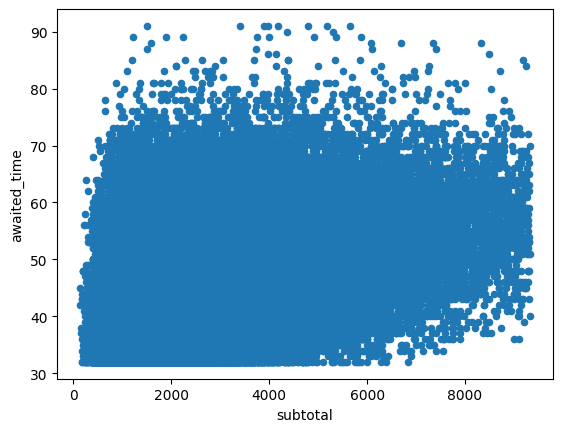

In [ ]:
df.plot(x='subtotal', y='awaited_time',
           kind='scatter')
plt.show()

O apresentado anteriormente pode ser confirmado também por esse gráfico

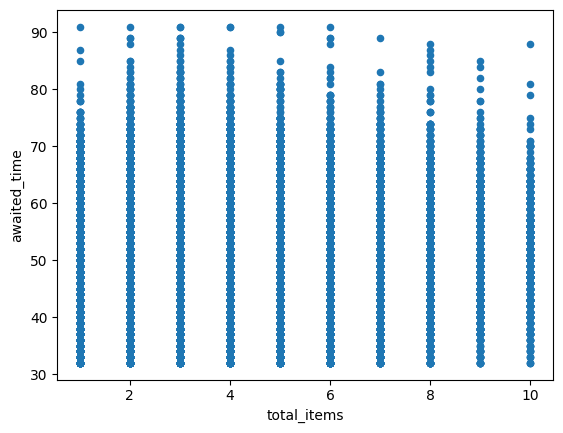

In [ ]:
df.plot(x='total_items', y='awaited_time',
           kind='scatter')
plt.show()

Esse também reafirma o que foi dito, visto que não necessariamente uma quantidade maior de itens está relacionada com um maior tempo de espera

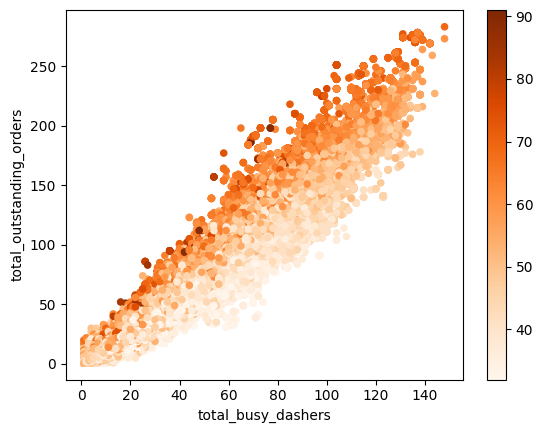

In [ ]:
# criando um gráfico entre o numero de entregadores ocupados, total de pedidos pendentes e tempo de espera
df.plot(x='total_busy_dashers', y='total_outstanding_orders', c=df['awaited_time'],
           cmap = 'Oranges',kind='scatter')
plt.show()

Assim como o esperado, o tempo total de espera aumenta conforme o número de pedidos pendentes cresce e o número de entregadores ocupados aumenta, indicando um problema de entrega, visto que não é um problema de cozinha

## ANALISE POR LOCAL

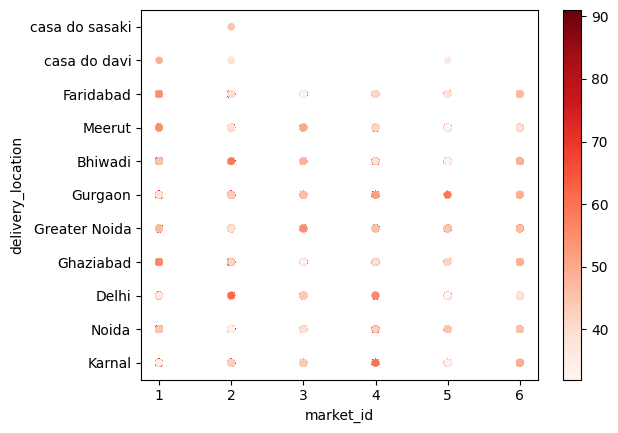

In [ ]:
# criando um grafico para fazer a relação entre cada local de entrega, o restaurante que fez a entrega e o tempo de espera
df.plot(x='market_id', y='delivery_location',
        c=df['awaited_time'], cmap = 'Reds',kind='scatter')
plt.show()

Com esse gráfico podemos analisar qual local cada restaurante está demorando mais para realizar a entrega, podendo prioriza-los.
Dado isso podemos tentar realizar alguns testes para tentar aumentar a eficiência, fazendo com que alguns restaurantes parem de entregar em certos locais, sendo algumas propostas citadas a seguir:


*   Restaurante 4 não entregar mais na Karnal, passando as entregas pro restaurante 1
*   Restaurante 2 não entregar mais na Delhi, passando as estregas pro restaurante 5

*    Restaurante 5 não entregar mais no Gurgaon, passando as entregas pro restaurante 2
*   Restaurante 1 não entregar mais na Faridabad, passando as entregas pro resturante 3

Dessa forma as entregas tendem a ficar mais rápidas, visto que será feito uma redistribuição delas para locais que tem menor tempo de entrega. Entretanto essa mudança tem que ser observada pois pode sobrecarregar algum restaurante, fazendo com as entregas no geral sejam mais demoradas. Acredito que 1-2 meses de teste seria de grandes efeitos para a empresa.





In [ ]:
# codigo que utilizei para calcular o quanto de vezes a entrega demorou mais de 60 minutos por local:

# o = 0
# for a in range (len(df)):
#   if 'Noida' in df['delivery_location'].iloc[a]:
#      if df['awaited_time'].iloc[a] > 60:
#         o += 1

# print(o)

# acredito que tenha uma forma de calcular isso com alguma biblioteca, porém não me veio nada na cabeça

Total de entregas que demoraram mais que 60 minutos: Greater Noida = 871, Meerut = 847, Karnal = 825, Faridabad = 910, Gurgaon = 853, Bhiwad = 929, Ghaziabad = 848, Delhi = 911, Noida = 1765

Sendo assim, podemos perceber que os locais que tiveram um maior volume de entregas com tempo de espera maior que 60 minutos foram o de Noida, Bhiwad e Faridabad.
Dado isso devemos dar uma atenção maior para as entregas principalmente no local Noida, visto que está com aproximadamente o dobro de casos a mais que a média dos outros.
Logo, eu pensaria em disponibilizar mais entregadores para a região ou deixar alguns entregadores para fazerem a entrega especificamente no local, reduzindo em grande parte os casos

In [ ]:
dl = df.groupby('delivery_location')
dl.mean().round(2)

<ipython-input-10-6fd03d3eca10>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dl.mean().round(2)


,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,awaited_time
delivery_location,,,,,,,,,,,,,
Bhiwadi,2.86,36.18,2.91,2.97,2586.52,2.59,680.05,1135.86,48.30,41.96,61.54,9.12,45.74
Delhi,2.84,36.02,2.91,2.98,2584.91,2.59,676.29,1135.73,46.89,40.57,59.24,9.14,45.66
Faridabad,2.84,36.44,2.88,2.98,2587.51,2.60,673.86,1137.20,48.72,42.16,61.71,9.10,45.68
Ghaziabad,2.85,35.91,2.89,2.96,2562.67,2.58,677.78,1127.31,47.78,41.34,60.35,9.07,45.48
Greater Noida,2.86,36.30,2.92,3.00,2580.54,2.59,674.29,1128.61,48.35,41.79,61.06,9.07,45.45
Gurgaon,2.83,35.97,2.91,2.95,2549.54,2.57,678.96,1126.95,47.82,41.23,60.30,9.07,45.40
Karnal,2.86,36.15,2.90,2.95,2574.65,2.56,683.17,1132.61,47.86,41.35,60.22,9.07,45.44
Meerut,2.83,36.39,2.93,2.96,2577.05,2.57,685.87,1133.75,47.82,41.36,60.36,9.11,45.50
Noida,2.84,35.80,2.90,2.99,2590.69,2.59,677.83,1130.01,48.39,41.86,61.09,9.17,45.61


Fiz a analise so pra ver se tinha algo muito discrepante, porém tudo conforme os padrões.
Também podemos concluir que o Davi e o Sasaki são ricos pois gastam 1880 e 3835 em média, respectivamente, em pedidos no restaurante.

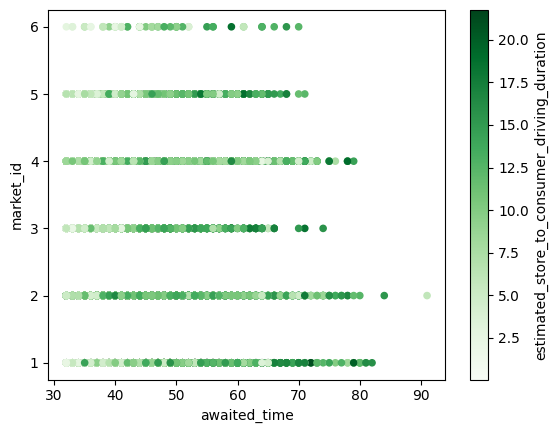

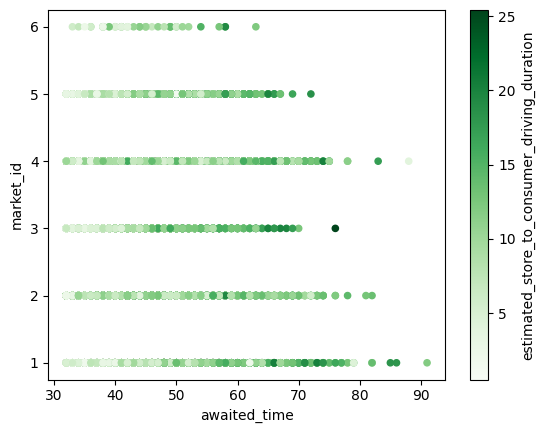

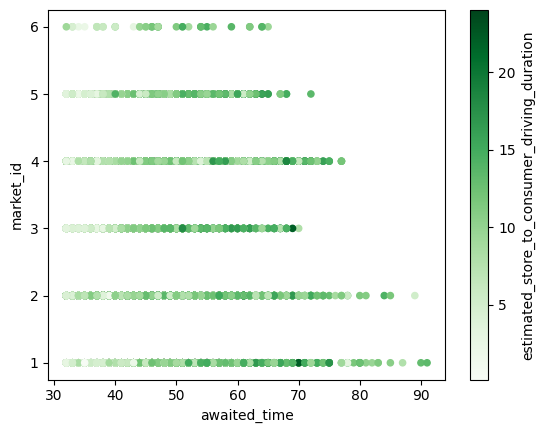

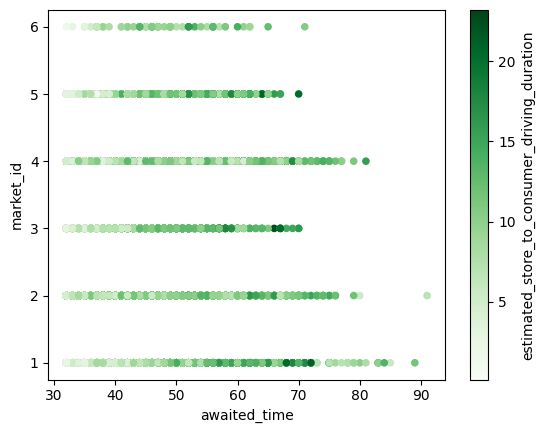

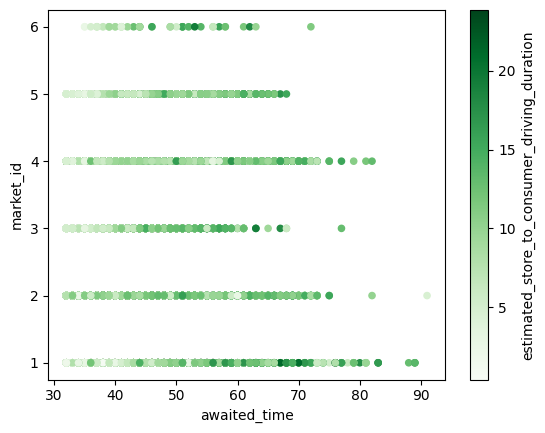

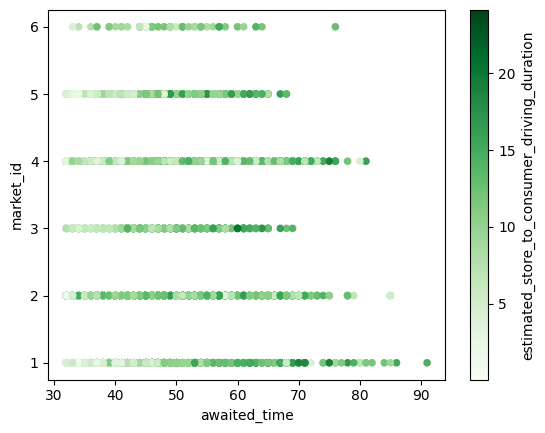

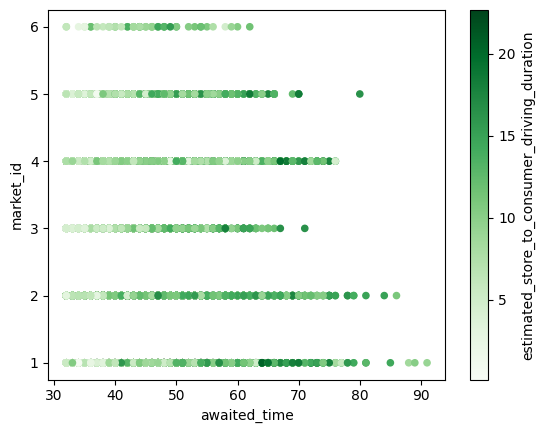

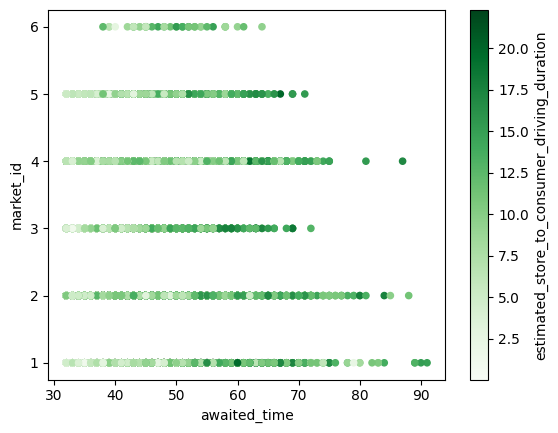

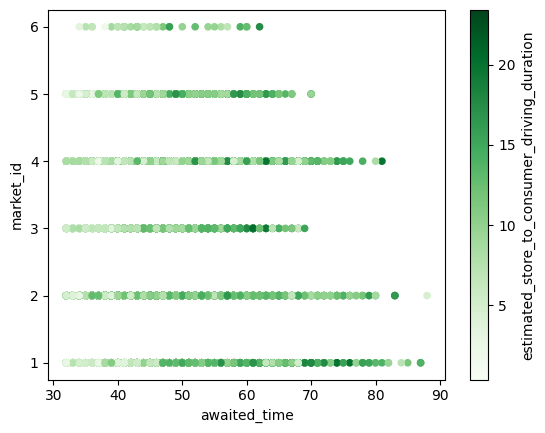

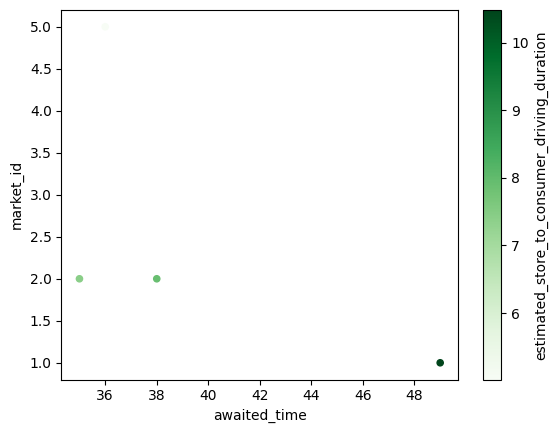

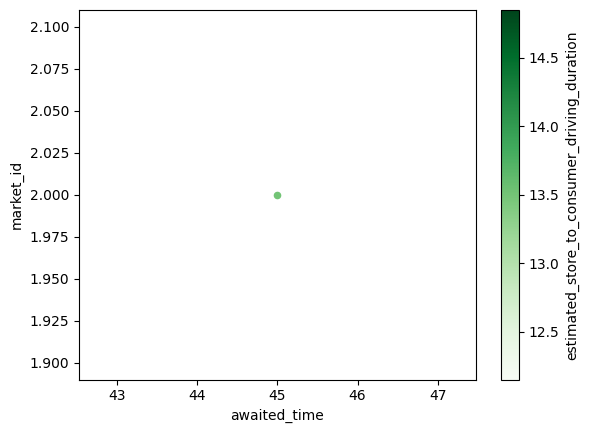

In [ ]:
# criando um grafico para analisar a relação entre tempo de espera, mercado e tempo estimado de entrega
dl.plot(x='awaited_time', y='market_id', c='estimated_store_to_consumer_driving_duration',
           cmap = 'Greys',kind='scatter')
plt.show()

Em uma analise geral podemos utilizar esses graficos para analisar os restaurantes que estão com maiores casos de tempo de espera discrepantes (70-90min). Também podemos utiliza-los para verificar cada localidade de entrega.
No caso geral podemos perceber que os Restaurantes 1 e 4 são os que mais estão tendo atrasos grandes, como apresentado pelos graficos. Dado isso poderiamos pensar em aumentar o numero de entregadores desses dois restaurantes, otimizando o tempo de entrega, assim como também retirar alguns locais de entrega, como proposto anteriormente, diminuindo a sobrecarga dos entregadores


Pela analise do grafico do Noida (antepenúltimo), que é o caso mais discrepante, devemos analisar mais profundamente o que está ocorrendo nos restaurantes 1,2 e 4 para entregas nesse local, visto que o tempo estimado de entrega é em torno de 15 minutos mas está ocorrendo muitos casos com tempo de espera acima de 70. Com mais informações fornecidas por esses restaurantes poderemos chegar a uma conclusão melhor.

In [ ]:
dl.max()

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,awaited_time
delivery_location,,,,,,,,,,,,,,,
Bhiwadi,6.0,2015-12-02 23:25:00,2015-12-02 23:58:00,72.0,7.0,10.0,9317.0,9.0,2900.0,3150.0,169.0,148.0,278.0,21.750000,91.0
Delhi,6.0,2015-12-02 23:23:00,2015-12-02 23:59:00,72.0,7.0,10.0,9320.0,9.0,2900.0,3179.0,164.0,143.0,278.0,25.416667,91.0
Faridabad,6.0,2015-12-02 23:22:00,2015-12-02 23:55:00,72.0,7.0,10.0,9340.0,9.0,2900.0,3100.0,160.0,142.0,278.0,24.033333,91.0
Ghaziabad,6.0,2015-12-02 23:12:00,2015-12-02 23:54:00,72.0,6.0,10.0,9300.0,9.0,2900.0,3180.0,171.0,142.0,278.0,23.183333,91.0
Greater Noida,6.0,2015-12-02 23:11:00,2015-12-02 23:51:00,72.0,7.0,10.0,9316.0,9.0,2900.0,3150.0,160.0,142.0,278.0,23.850000,91.0
Gurgaon,6.0,2015-12-02 23:21:00,2015-12-02 23:59:00,72.0,7.0,10.0,9327.0,9.0,2900.0,3179.0,168.0,138.0,276.0,24.133333,91.0
Karnal,6.0,2015-12-02 23:21:00,2015-12-02 23:57:00,72.0,7.0,10.0,9300.0,9.0,2900.0,3100.0,165.0,148.0,283.0,22.683333,91.0
Meerut,6.0,2015-12-02 23:17:00,2015-12-02 23:58:00,72.0,7.0,10.0,9300.0,9.0,2900.0,3144.0,160.0,142.0,278.0,22.316667,91.0
Noida,6.0,2015-12-02 23:23:00,2015-12-02 23:56:00,72.0,7.0,10.0,9292.0,9.0,2900.0,3174.0,160.0,144.0,278.0,23.400000,88.0


Algo curioso que da pra tirar desse gráfico é que apesar de Noida ser o lugar que tem a maior incidência de tempos de espera altos, ele nunca atingiu o tempo de espera máximo, porém não acredito que isso indique algo relevante

In [ ]:
dl.min()

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,awaited_time
delivery_location,,,,,,,,,,,,,,,
Bhiwadi,1.0,2015-01-02 00:01:00,2015-01-02 00:41:00,2.0,1.0,1.0,125.0,1.0,8.0,100.0,1.0,1.0,1.0,0.050000,32.0
Delhi,1.0,2015-01-02 00:03:00,2015-01-02 00:43:00,1.0,1.0,1.0,149.0,1.0,20.0,99.0,1.0,1.0,1.0,0.516667,32.0
Faridabad,1.0,2015-01-02 00:04:00,2015-01-02 00:39:00,2.0,1.0,1.0,174.0,1.0,10.0,99.0,1.0,1.0,1.0,0.183333,32.0
Ghaziabad,1.0,2015-01-02 00:00:00,2015-01-02 00:33:00,2.0,1.0,1.0,179.0,1.0,15.0,109.0,1.0,1.0,1.0,0.166667,32.0
Greater Noida,1.0,2015-01-02 00:01:00,2015-01-02 00:49:00,2.0,1.0,1.0,139.0,1.0,11.0,99.0,1.0,1.0,1.0,0.416667,32.0
Gurgaon,1.0,2015-01-02 00:01:00,2015-01-02 00:34:00,1.0,1.0,1.0,175.0,1.0,25.0,75.0,1.0,1.0,1.0,0.050000,32.0
Karnal,1.0,2015-01-02 00:00:00,2015-01-02 00:51:00,1.0,1.0,1.0,198.0,1.0,16.0,99.0,1.0,1.0,1.0,0.133333,32.0
Meerut,1.0,2015-01-02 00:09:00,2015-01-02 00:46:00,1.0,1.0,1.0,175.0,1.0,10.0,99.0,1.0,1.0,1.0,0.050000,32.0
Noida,1.0,2015-01-02 00:00:00,2015-01-02 00:44:00,1.0,1.0,1.0,200.0,1.0,15.0,99.0,1.0,1.0,1.0,0.383333,32.0


In [ ]:
mi = df.groupby('market_id')
mi.mean().round(2)

<ipython-input-15-5706e5f321a1>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mi.mean().round(2)


,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,awaited_time
market_id,,,,,,,,,,,,
1.0,34.23,2.72,2.95,2551.85,2.55,684.29,1119.10,25.62,23.59,30.01,8.63,47.52
2.0,36.32,3.12,2.94,2559.90,2.54,680.99,1140.35,67.37,57.63,85.36,9.44,44.34
3.0,33.90,2.51,2.96,2508.38,2.57,659.45,1087.57,20.55,17.81,20.12,8.92,43.27
4.0,38.95,3.15,3.07,2739.17,2.68,689.94,1172.45,63.20,55.28,85.59,9.12,46.81
5.0,34.14,2.43,2.88,2335.47,2.52,655.95,1078.09,24.86,19.30,26.82,9.12,44.81
6.0,35.96,2.86,3.02,2568.79,2.59,674.70,1097.53,46.02,40.17,58.85,9.32,46.71


A partir desse gráfico que calcula a media para cada restaurante podemos chegar a mesma conclusão que comentamos anteriormente, que o restaurante 1 e 4 estão com problemas de entrega, visto que tem uma media maior de tempo de entrega, assim como o restaurente 6.
Outra coisa que pode ser citada é que o restaurante 4 geralmente tem pedidos mais caros e com mais itens

In [ ]:
mi.max()

,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,delivery_location,estimated_store_to_consumer_driving_duration,awaited_time
market_id,,,,,,,,,,,,,,,
1.0,2015-12-02 23:22:00,2015-12-02 23:59:00,72.0,6.0,10.0,9316.0,9.0,2900.0,3179.0,150.0,129.0,228.0,casa do davi,24.033333,91.0
2.0,2015-12-02 23:21:00,2015-12-02 23:53:00,72.0,6.0,10.0,9320.0,9.0,2900.0,3179.0,171.0,148.0,283.0,casa do sasaki,22.683333,91.0
3.0,2015-12-02 23:20:00,2015-12-02 23:58:00,72.0,6.0,10.0,9250.0,9.0,2900.0,3180.0,160.0,142.0,269.0,Noida,25.416667,77.0
4.0,2015-12-02 23:25:00,2015-12-02 23:58:00,72.0,6.0,10.0,9340.0,9.0,2900.0,3161.0,153.0,142.0,272.0,Noida,24.133333,88.0
5.0,2015-12-02 23:17:00,2015-12-02 23:59:00,72.0,7.0,10.0,9316.0,9.0,2900.0,3150.0,169.0,134.0,238.0,casa do davi,22.000000,80.0
6.0,2015-12-02 23:17:00,2015-12-02 23:58:00,72.0,6.0,10.0,9274.0,9.0,2900.0,2900.0,151.0,132.0,257.0,Noida,19.916667,76.0


Foi comentado anteriormente que o restaurante 6 estava com problemas de entrega por ter uma média maior, porém tal informação pode ser descartada, visto que sua eficiência está grande, tendo que não teve nenhum pedido que passou dos 76 minutos de espera. Outro ponto a se colocar é sobre o restaurante 3 e 5, que não ultrapassaram em nenhum pedido os 80 minutos. Dito isso coloco a proposta de dar algum benefício para tais restaurantes, entretanto deixo em aberto para podermos chegar a algo benéfico para a empresa e para parabenizar a efetividade dos dois restaurantes.

In [ ]:
mi.min()

,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,delivery_location,estimated_store_to_consumer_driving_duration,awaited_time
market_id,,,,,,,,,,,,,,,
1.0,2015-01-02 00:03:00,2015-01-02 00:46:00,2.0,1.0,1.0,198.0,1.0,15.0,99.0,1.0,1.0,1.0,Bhiwadi,0.050000,32.0
2.0,2015-01-02 00:00:00,2015-01-02 00:39:00,1.0,1.0,1.0,175.0,1.0,8.0,109.0,1.0,1.0,1.0,Bhiwadi,0.050000,32.0
3.0,2015-01-02 00:03:00,2015-01-02 00:46:00,2.0,1.0,1.0,139.0,1.0,11.0,99.0,1.0,1.0,1.0,Bhiwadi,0.083333,32.0
4.0,2015-01-02 00:00:00,2015-01-02 00:33:00,2.0,1.0,1.0,125.0,1.0,19.0,100.0,1.0,1.0,1.0,Bhiwadi,0.050000,32.0
5.0,2015-01-02 00:04:00,2015-01-02 00:44:00,2.0,1.0,1.0,175.0,1.0,16.0,75.0,1.0,1.0,1.0,Bhiwadi,0.050000,32.0
6.0,2015-01-02 00:24:00,2015-01-02 01:14:00,2.0,1.0,1.0,328.0,1.0,25.0,169.0,1.0,1.0,1.0,Bhiwadi,1.600000,32.0


# **CONCLUSÃO**

Pelo apresentado anteriormente, podemos chegar a algumas conclusões:


*   O total de itens não está diretamente relacionado com o tempo de espera, o que nos demonstra uma eficiência grande na cozinha ao entregar uma quantidade maior de produtos com diferenças não tão grandes de tempo. Dito isso o tempo de espera alto é um problema relacionado a entrega
*   Temos um gráfico que apresenta as 'dificuldades' de cada restaurante, sendo assim realizaremos testes especificos para cada um
*   Os locais que mais tem incidência de altos tempos de espera é os de Noida, Bhiwad e Faridabad
*   Davi e Sassaki são ricos
*   O caso de entregas no local Noida é o que precisa de mais atenção, visto que este apresenta quase o dobro de casos com demoras grandes, sendo os restaurantes 1,2 e 4 os que mais atrasam.
*   O restaurante 4 geralmente tem pedidos mais caros e com um numero maior de itens
*   Os restaurantes 1 e 4 estão com problemas na entrega, visto que apresentam grandes médias de tempo de espera
*   Os restaurantes 3 e 5 estão com ótima eficiência na entrega, pois nenhum dos pedidos ultrapassou os 80 minutos




Com isso proponho que:
*   Restaurante 4 não entregue mais na Karnal, passando as entregas pro restaurante 1
*   Restaurante 2 não entregue mais na Delhi, passando as estregas pro restaurante 5
*    Restaurante 5 não entregue mais no Gurgaon, passando as entregas pro restaurante 2
*   Restaurante 1 não entregue mais na Faridabad, passando as entregas pro resturante 3
*   Deixem entregadores especificos para Noida, Bhiwad e Faridabad
*   Aumentem o número de entregadores nos restaurantes 1 e 4 e analisem os entregadores desses restaurantes, podendo fazer a troca daqueles que 'enrolam'
*   Façam uma campanha voltada para as entregas, dando algo como benefício para os restaurantes que tiverem menores discrepãncias de entrega e taxas mais baixas, dando ínicio com os restaurantes 3 e 5

# **PREDIÇÃO**

In [ ]:
df.to_csv('database_limpo.csv', index=False)

In [ ]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

# separando a base para analisar o tempo de espera
X = df.iloc[:, 0:15]
y = df.iloc[:, 15]

# transformando os valores
ohe = OneHotEncoder()
X = ohe.fit_transform(X)

# dividindo a base em treinamento e teste
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X, y, test_size = 0.2, stratify = y)


knn = KNeighborsClassifier()
knn.fit(X_treinamento, y_treinamento)
previsaoknn = knn.predict(X_teste)

acsknn = accuracy_score(y_teste, previsaoknn)

arvore = DecisionTreeClassifier()
arvore.fit(X_treinamento, y_treinamento)
previsaoarvore = arvore.predict(X_teste)

acsarvore = accuracy_score(y_teste, previsaoarvore)

# O CODIGO A SEGUIR SERIA A FORMA QUE EU FARIA O PREDICT, PORÉM DEMORARIA ABSURDOS PARA RODAR

# criando listas para eu poder analisar a media de qual predict teve melhores resultados
# resultados_arvore = []
# resultados_random_forest = []
# resultados_knn = []
# resultados_logistica = []
# resultados_svm = []
# resultados_rede_neural = []

# realizar uma classificação cruzada de todas as bases para poder ver qual terá maior acertividade e menor discrepância, para isso irei utilizar uma estrutura de repetiçao for

# for i in range(20):

  # kfold = KFold(n_splits=10, shuffle=True, random_state=i)

  # arvore = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=1, min_samples_split=5, splitter='best')
  # scores = cross_val_score(arvore, X, y, cv = kfold)
  # resultados_arvore.append(scores.mean())

  # random_forest = RandomForestClassifier(criterion = 'entropy', min_samples_leaf = 1, min_samples_split=5, n_estimators = 10)
  # scores = cross_val_score(random_forest, X, y, cv = kfold)
  # resultados_random_forest.append(scores.mean())

  # knn = KNeighborsClassifier()
  # scores = cross_val_score(knn, X, y, cv = kfold)
  # resultados_knn.append(scores.mean())

  # logistica = LogisticRegression(C = 1.0, solver = 'lbfgs', tol = 0.0001)
  # scores = cross_val_score(logistica, X_credit, y_credit, cv = kfold)
  # resultados_logistica.append(scores.mean())

  # svm = SVC(kernel = 'rbf', C = 2.0)
  # scores = cross_val_score(svm, X_credit, y_credit, cv = kfold)
  # resultados_svm.append(scores.mean())

  # rede_neural = MLPClassifier(activation = 'relu', batch_size = 56, solver = 'adam')
  # scores = cross_val_score(rede_neural, X_credit, y_credit, cv = kfold)
  # resultados_rede_neural.append(scores.mean())

  # resultados = pd.DataFrame({'Arvore': resultados_arvore, 'RF': resultados_random_forest})

# pegar a descrição do df para poder ver qual terá melhores resultados e menor discrepância
# resultados.describe()

0.05065193370165746

In [ ]:
acsarvore

0.05065193370165746

In [ ]:
acsknn

0.05935911602209945

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_teste, previsaoknn)

-0.5787120676563688

In [ ]:
r2_score(y_teste, previsaoarvore)

-0.31499825992790775

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_teste, previsaoknn)

8.533834254143647

In [ ]:
mean_absolute_error(y_teste, previsaoarvore)

7.819491712707182

Apesar do KNN estar com um erro absoluto maior, esse valor não compensa a diferença entre a porcentagem de acerto entre ambos. O KNN tem maior acerto, com 0.59, com diferença de 0.09 pra arvore, entretanto tem uma diferença menor que 1 pro erro. Logo, devemos usar de preferência o KNN, visto que nos trará melhores resultados